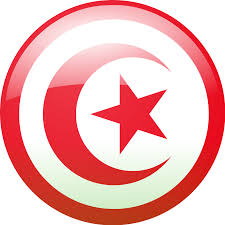

# Estimate the confirmed covid-19-cases in Tunisia for up to 2 weeks in future with LGBM and Keras
* based on global (country/region-wise) developments of confirmation rates including covid_19 and sars_03 outbreaks
* Updated daily



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os

from matplotlib import pyplot as plt
#  option for print all columns in the dataframes
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# end for options
import copy
from datetime import datetime, timedelta
from scipy import stats

import plotly.express as px
template = 'plotly_dark'
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')

# Seeing things in a simple way
* Visualisation

In [ ]:
df = pd.read_excel("../input/tunisa-regions-cov19/RegioCov-19.xlsx",sheet_name="RegioTime")
df.dtypes
df2 = df.copy()
#df1.rename(columns={'DateConf':'date',
 #                         'Confirmed':'confirmed',
  #                'Gouvernorat':'region'}, inplace=True)
df2.rename(columns={'DateConf':'date',
                          'Confirmed':'confirmed',
                  'Gouvernorat':'region'}, inplace=True)

# convert date in the target format for plotting the map
df2['date'] = df2['date'].dt.strftime('%d/%m/%Y')

In [ ]:
fig = px.scatter_mapbox(df2, 
                     lat = df2["Latitude"], lon = df2["Longitude"],
                     color="confirmed", size="confirmed", hover_name="region", 
                     range_color= [0, max(df2['confirmed'])+2],  color_continuous_scale='Bluered',
                      animation_frame="date", height = 720, size_max  = 50,zoom=5,
                     # template = template,
                     title='Spread in Tunisia over time: Region')

fig.update_layout(mapbox_style="open-street-map")

fig.show()

SARS in 2003 outbreak seems to have much in common with current COVID-19 outbreak. Hence, use additional SARS data for training.

In [ ]:
#df_covid_19 = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
df_covid_19 = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
df_covid_19['Date'] = pd.to_datetime(df_covid_19['ObservationDate'])
df_covid_19['Outbreak'] = 'COVID_2019'
df_covid_19.columns

In [ ]:
df_sars_03 = pd.read_csv("../input/sars-outbreak-2003-complete-dataset/sars_2003_complete_dataset_clean.csv")
df_sars_03['Date'] = pd.to_datetime(df_sars_03['Date'])
df_sars_03['Province/State'] = None
df_sars_03['Outbreak'] = 'SARS_2003'
print(df_sars_03.columns)
df_sars_03.rename({'Cumulative number of case(s)':'Confirmed', 'Number of deaths':'Deaths', 'Number recovered':'Recovered', 'Country':'Country/Region'},axis=1,inplace=True)

In [ ]:
templ_cols = ['Outbreak', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']
df = pd.concat([df_covid_19[templ_cols], df_sars_03[templ_cols]])
df = df.reset_index(drop=True)

In [ ]:
df['Confirmed'] = df['Confirmed'].fillna(0)
df['Province/State'] = df['Province/State'].fillna('Others')
df = df.sort_values(['Country/Region','Province/State','Date'])

In [ ]:
df = df.groupby(['Outbreak','Country/Region','Province/State','Date']).agg({'Confirmed':'sum'}).reset_index()
df['Province/State'] = 'all'

### Remove countries with minor confirmation numbers

In [ ]:
t = df.groupby(['Outbreak','Country/Region','Province/State']).agg({'Confirmed':'max'})
t = t.loc[t['Confirmed'] > 2]
df = pd.merge(df,t[[]],left_on=['Outbreak','Country/Region','Province/State'], right_index=True)

In [ ]:
df['Country/Region'].value_counts()

In [ ]:
country_data = pd.read_csv("../input/countries-of-the-world/countries of the world.csv")
country_data['Country'] = country_data['Country'].str.strip()
country_data

In [ ]:
df.loc[df['Country/Region']=='US','Country/Region'] = 'United States'
df.loc[df['Country/Region']=='Mainland China','Country/Region'] = 'China'
df.loc[df['Country/Region']=='Viet Nam','Country/Region'] = 'Vietnam'
df.loc[df['Country/Region']=='UK','Country/Region'] = 'United Kingdom'
df.loc[df['Country/Region']=='South Korea','Country/Region'] = 'Korea, South'
df.loc[df['Country/Region']=='Taiwan, China','Country/Region'] = 'Taiwan'
df.loc[df['Country/Region']=='Hong Kong SAR, China','Country/Region'] = 'Hong Kong'

df = pd.merge(df, country_data, how='left', left_on=['Country/Region'], right_on=['Country'])
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.loc[df['Country'].isnull()]['Country/Region'].value_counts()

In [ ]:
df.loc[df['Region'].isnull(), 'Region'] = 'Others'
df.loc[df['Country'].isnull(), 'Country'] = 'Undefined'

In [ ]:
df['Country'].value_counts()

In [ ]:
fix, ax = plt.subplots(figsize=(16,6), ncols=2)
s0 = df['Confirmed']
s0.plot.hist(ax=ax[0])

# BoxCox
#from sklearn.preprocessing import PowerTransformer
#transformer = PowerTransformer(method='box-cox', standardize=True)
#s0 = s0+1

# Normalise and reshape
#from sklearn.preprocessing import FunctionTransformer
#transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler(feature_range=(0,1)).fit(np.asarray([0, 2E5]).reshape(-1,1)) # df['Confirmed'].values.reshape(-1,1)

s1 = pd.Series(transformer.transform(s0.values.reshape(-1,1)).reshape(-1))
s1.plot.hist(ax=ax[1])
df['Confirmed_transformed'] = s1 # make sure that every value is positive

# Feature engineering

In [ ]:
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week

#### Lags
  We use a 10-day-lag window to estimate the future development

In [ ]:
n_lags = 15
for k,v in df.groupby(['Outbreak','Country/Region','Province/State']):    
    for d in range(n_lags,0,-1):                
        df.loc[v.index, f'Confirmed_Lag_{d}'] = v['Confirmed'].shift(d)
        #df.loc[v.index, f'Confirmed_Rolling_Mean_Lag{d}'] = v['Confirmed'].shift(d).rolling(n_lags).mean()
        df.loc[v.index, f'Confirmed_Transformed_Lag_{d}'] = v['Confirmed_transformed'].shift(d)

X_mask_lags = [c for c in df.columns if 'Confirmed_Lag_' in c]# + [c for c in df.columns if 'Confirmed_Rolling_Mean_Lag' in c]
X_mask_lags_transformed = [c for c in df.columns if 'Confirmed_Transformed_Lag_' in c]

df[X_mask_lags] = df[X_mask_lags].fillna(0)
df[X_mask_lags_transformed] = df[X_mask_lags_transformed].fillna(0)

print(f'Dataframe shape {df.shape}')

# Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc_outb = LabelEncoder().fit(df['Outbreak'])
df['Outbreak_enc'] = enc_outb.transform(df['Outbreak'])

enc_ctry = LabelEncoder().fit(df['Country/Region'])
df['Country_enc'] = enc_ctry.transform(df['Country/Region'])

enc_region = LabelEncoder().fit(df['Region'])
df['Region_enc'] = enc_region.transform(df['Region'])

# LGBM

In [ ]:
from sklearn.model_selection import train_test_split

X_mask_cat = ['Outbreak_enc','Region_enc', 'Month','Week']
train_test = df.loc[df['Confirmed'] > 2].copy()
s_unique_values = train_test[X_mask_lags].apply(lambda r: len(np.unique(r.values)), axis=1)
train_test = train_test.loc[s_unique_values > 1].copy()
print(f'Train/Test shape {train_test.shape}')

train, valid = train_test_split(train_test, test_size=0.3, shuffle=True, random_state=231321)

In [ ]:
from lightgbm import LGBMRegressor    
model_lgbm = LGBMRegressor(n_estimators=100000, metric='rmse', random_state=1234, min_child_samples=5, min_child_weight=0.00000001,application = 'regression'
                          , boosting = 'dart',num_leaves = 51, device = 'gpu',learning_rate = 0.003, max_bin = 63, num_iterations = 500 )

print(f'Fitting on data with shape {train[X_mask_cat+X_mask_lags].shape} with validation of shape {valid[X_mask_cat+X_mask_lags].shape}')

model_lgbm.fit(X=train[X_mask_cat+X_mask_lags], y=train['Confirmed'], 
               eval_set=(valid[X_mask_cat+X_mask_lags], valid['Confirmed']),
               early_stopping_rounds=100, verbose=5000)


Out-of-sample prediction with 5-steps (days)

In [ ]:
from datetime import timedelta
pred_steps = 10

history = df.loc[(df['Outbreak']=='COVID_2019') & (df['Confirmed'] > 2) & (df['Country/Region']=='Tunisia')]
history0 = history.iloc[-1]

dt_rng = pd.date_range(start=history0['Date']+timedelta(days=1), 
                       end=history0['Date']+timedelta(days=pred_steps),freq='D').values
dt_rng = pd.to_datetime(dt_rng)

pred_months = pd.Series(dt_rng).apply(lambda dt: dt.month)
pred_weeks = pd.Series(dt_rng).apply(lambda dt: dt.week)

pred_cat = history0[X_mask_cat].values
pred_lags = history0[X_mask_lags].values
y = history0['Confirmed']

print('History 0: ', pred_lags)
pred_lags[:n_lags] = np.roll(pred_lags[:n_lags], -1)
pred_lags[n_lags-1] = y  # Lag
#pred_lags[n_lags:] = np.roll(pred_lags[n_lags:], -1)
#pred_lags[-1] = np.mean(pred_lags[:n_lags]) # rolling_mean
print('Pred 0: ', pred_lags)

pred = np.zeros(pred_steps)
for d in range(pred_steps):     
    pred_cat[1] = pred_months[d]
    pred_cat[2] = pred_weeks[d]    
    
    y = model_lgbm.predict(np.hstack([pred_cat, pred_lags]).reshape(1,-1))[0]
    #print(f'Prediction body: ', np.hstack([pred_cat, pred_lags]).reshape(1,-1))
    print(f'Step {d}, predicted for {dt_rng[d].strftime("%Y-%m-%d")} is: {y}')
    
    pred_lags[:n_lags] = np.roll(pred_lags[:n_lags], -1)
    pred_lags[n_lags-1] = y  # Lag    
 #   pred_lags[n_lags:] = np.roll(pred_lags[n_lags:], -1)
 #   pred_lags[-1] = np.mean(pred_lags[n_lags:]) # rolling_mean

    pred[d] = y
    
preds = pd.Series(data=pred, index=dt_rng, name='LGBM predicted')

# Neural network (KERAS-based)

Use a model which is comprising some categorical informations (via embedding layers) and a LSTM structure to learn the time-dependent behavior.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector, Input, Concatenate, Flatten, Reshape, Embedding
from tensorflow.keras.backend import clear_session
import keras
clear_session()

inp_outbreak = Input(shape=(1,1))
inp_country = Input(shape=(1,1))
inp_lags = Input(shape=(n_lags,1))

emb_outbreak = Embedding(input_dim=2, output_dim=1)(inp_outbreak)
emb_country = Embedding(input_dim=200, output_dim=2)(inp_country)

lstm1 = LSTM(64, activation='linear', return_sequences=True)(inp_lags)
lstm2 = LSTM(32, activation='linear', return_sequences=False)(lstm1)

concat1 = Reshape(target_shape=(1,3))(Concatenate(axis=3)([emb_outbreak, emb_country]))
concat2 = Concatenate(axis=1)([Flatten()(concat1), lstm2])
dense1 = Dense(32, activation='linear')(concat2)
dense2 = Dense(1, activation='linear')(dense1)

model_keras = Model(inputs=[inp_outbreak, inp_country, inp_lags], outputs=[dense2])
model_keras.compile(loss='mean_squared_error', optimizer='adam')
model_keras.summary()


def prepare_keras_input(data):
    lags = data[X_mask_lags_transformed].values.reshape(-1, 15, 1)
    y = data['Confirmed_transformed'].values.reshape(-1,1)    
    
    return [data['Outbreak_enc'].values.reshape(-1,1,1), 
            data['Country_enc'].values.reshape(-1,1,1), lags], y
    
train_X, train_y = prepare_keras_input(train)
model_keras.fit(train_X, train_y, validation_data=(prepare_keras_input(valid)), epochs=50, verbose=0,validation_steps=10,use_multiprocessing=True)


* Out-of-sample prediction with 3-steps (days)

In [ ]:
from datetime import timedelta
from tensorflow import convert_to_tensor

pred_steps = 10

history = df.loc[(df['Outbreak']=='COVID_2019') & (df['Confirmed'] > 2) & (df['Country/Region']=='Tunisia')]
history0 = history.iloc[-1]

pred_cat_outbreak = convert_to_tensor(history0['Outbreak_enc'].reshape(-1,1,1), np.int32)
pred_cat_country = convert_to_tensor(history0['Country_enc'].reshape(-1,1,1), np.int32)

pred_lags = history0[X_mask_lags_transformed].values
y = history0['Confirmed_transformed']

#print('History 0: ', pred_lags)
pred_lags = np.roll(pred_lags, -1)
pred_lags[-1] = y

#print('Pred 0: ', pred_lags)
pred = np.zeros(pred_steps)

dt_rng = pd.date_range(start=history0['Date']+timedelta(days=1), 
                       end=history0['Date']+timedelta(days=pred_steps),freq='D').values
dt_rng = pd.to_datetime(dt_rng)
# Scale
for d in range(pred_steps):    
    y = model_keras.predict([pred_cat_outbreak, pred_cat_country, convert_to_tensor(pred_lags.reshape(-1,15,1), np.float32)])[0][0]
    #print(f'Pred body: {pred_lags}')
    print(f'Step {d}, predicted for {dt_rng[d].strftime("%Y-%m-%d")} is: {transformer.inverse_transform(y.reshape(-1,1)).reshape(-1)}')
    
    pred_lags = np.roll(pred_lags, -1)
    pred_lags[-1] = y    
    pred[d] = y
    
pred = transformer.inverse_transform(pred.reshape(-1,1)).reshape(-1)
preds_keras = pd.Series(data=pred, index=dt_rng, name='Keras predicted')

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(16,7))

hist = history.set_index(['Date'])['Confirmed'].plot(ax=ax, marker='o')
preds.plot(ax=ax, marker='o', linewidth=2)
preds_keras.plot(ax=ax, marker='*')
plt.legend()
plt.tight_layout()

# Saving the output

In [ ]:
import datetime
ts = datetime.datetime.now().strftime('%Y%m%d')
df_out = pd.DataFrame([preds, preds_keras]).T
df_out.to_csv(f'{ts}_prediction.csv')

In [ ]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
df_ser = df[df['Country/Region']=='Tunisia']
df_ser

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

series = df_ser.loc[:,['Date','Confirmed']]
series['Date'] = pd.to_datetime(series['Date'])
dates = np.asarray(series['Date'])
series.reset_index()
series = df_ser.loc[:,['Confirmed']]



#conf = np.asarray(series['confirmed'])
#series = pd.Series(conf, index=dates,columns = ['confirmed'])
#series['confirmed'].values().index(dates)
#parse_dates
series = series.set_index(dates)
series

In [ ]:
autocorrelation_plot(series)
pyplot.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(series, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(series.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(series.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

In [ ]:
plot_pacf(series.diff().dropna(), lags=10)

In [ ]:
plot_acf(series.diff().dropna())

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = ARIMA(series, order=(0,1,1))
model_fit = model.fit(start_ar_lags=1 ,transparams=False)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = series.loc['2020-03-04':].plot(ax=ax)
model_fit.plot_predict('2020-04-01','2020-04-12',ax=ax,plot_insample=False)
plt.show()


In [ ]:
X = series.values
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(0,2,1))
    model_fit = model.fit(maxiter=200)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
   # print(model_fit.mle_retvals)
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)



In [ ]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:


#divide into train and validation set
train = series[:int(0.7*(len(series)))]
valid = series[int(0.7*(len(series))):]




#plotting the data
train['Confirmed'].plot()
valid['Confirmed'].plot()

In [ ]:
!pip install pyramid-arima

In [ ]:

#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, error_action='ignore', suppress_warnings=False,seasonal=False)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
print(adf_test(train['Confirmed']))

In [ ]:
from math import sqrt
rms = sqrt(mean_squared_error(valid,forecast))
print(rms)

# Bayesian Neural network

In [ ]:
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [ ]:
data = series
# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)

In [ ]:
# Restore frame.
dataset = pd.DataFrame(X_t, columns =['Confirmed'])
dataset = dataset.set_index(dates)
dataset

In [ ]:
# Define some hyperparameters.
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples
# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset['Confirmed'].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)
